In [1]:
cd ~/Dropbox/Documents/School/Projects/KBP_katrina_bond_to_private/data/emaxx/txt_files/

/home/gaulinmp/Dropbox/Documents/School/Projects/KBP_katrina_bond_to_private/data/emaxx/txt_files


In [2]:
# system/os/regex and basic math functions
import sys
import os
import re
import math
import pickle
import dateutil
import datetime as dt
from itertools import permutations as npn
from itertools import chain
from functools import partial
from fuzzywuzzy.process import extractBests, extract, extractOne
 
# IPython display convenience stuff
from IPython.display import display_html, display_javascript
from IPython import __version__ as ipythonversion
HTML = partial(display_html, raw=True)
print("IPython: {}".format(ipythonversion))
    
# Set logging level
import logging
logging.getLogger("").setLevel(logging.DEBUG)
 
# numpy for matrix algebra
import numpy as np
print("Numpy: {}".format(np.version.full_version))
 
# scipy for probability distributions and some statistical tests
import scipy as sp
import scipy.stats as stats
print("Scipy: {}".format(sp.version.full_version))
 
# pandas for data manipulation
import pandas as pd
print("Pandas: {}".format(pd.version.version))
 
# Set pandas display options for pretty pretty printing
pd.set_option('html', True, 'precision', 8)
pd.set_option('max_rows',200,'max_columns',50)
 
# pandas web interface for things like FF factors
import pandas.io.data as web
 
# pytables for hdf5 library (on-disk storage)
# import tables as tb
 
# SQLAlchemy for relational db management
import sqlalchemy as sa
print("SQLalchemy: {}".format(sa.__version__))

# matplotlib for plotting and pyplot for MATLAB-style API
import matplotlib as mpl
import matplotlib.pyplot as plt
print("MatPlotLib: {}".format(mpl.__version__))
 
# display plots inline
%matplotlib inline
 
# statsmodels for models with a formula framework similar to R 
import statsmodels.api as sm
print("Statsmodels: {}".format(sm.version.full_version))

debug = False
plots = True
KATRINA_DATE = dt.datetime(2005, 8, 23)

IPython: 3.1.0
Numpy: 1.9.2
Scipy: 0.15.1
Pandas: 0.16.0
SQLalchemy: 1.0.3
MatPlotLib: 1.4.3
Statsmodels: 0.6.1


Column headings from KBD_emaxx_cleaning.ipynb, but a subset that I care about. Not all.

In [3]:
col_str = """
ISSUERS.TXT: cusip6, year, quarter, name, name_sort, country, ticker
SECMAST.TXT: cusip6, cusip78, year, quarter, issue_desc, coupon_rate, coupon_structure, currency_code, maturity_year, maturity_date, market_sector, collateral_code, cusip_source, private, issue_amt_outstanding, issue_amt_change, num_held, num_buying, num_selling, total_par_held, pledge_code, issue_date, moody, s_and_p, fitch, duff_and_phelps
FUND.TXT: sub_account_id, year, quarter, sub_account_class, sub_account_name, sub_account_name_sort, managing_firm_id, sub_account_country, total_par_amt_held, total_number_bonds_held, update_date
HOLDING.TXT: cusip6, cusip78, sub_account_id, par_amount, report_date, par_amount_change, managing_firm_id, acquisition_book_value, year, quarter
FIRM.TXT: managing_firm_id, year, quarter, managing_firm_name, managing_firm_name_sort, managing_firm_type, managing_firm_country_code, managing_firm_total_par_held, managing_firm_number_issues_held
""".strip().split('\n')

column_headings = {ln.split(': ')[0]:ln.split(': ')[1].split(', ') for ln in col_str}

ROOTDIR = '/home/gaulinmp/Dropbox/Documents/School/Projects/KBP_katrina_bond_to_private/data/'

In [4]:
def add_column(df, name, func):
    """
    Adds a column to *df* named *name* which is created by:
    df[name] = df.apply(func, axis=1)
    """
    df[name] = df.apply(func, axis=1)
    return df

# Load small files into pandas and search for fund names

In [5]:
!head ../../compustat_cusips.tab -n 2

PERMNO	PERMCO	COMNAM	TICKER	cusip	cusip6	date_start	date_end	year	quarter	fic	comp
10006	22156	AMERICAN CAR & FDRY CO				1925-12-31	1954-05-31			USA	1


In [6]:
"""
Load all eMAXX files into pandas dataframes except HOLDING which is huge.
"""
dfs = {'firmtype':pd.read_csv('2002_Q2/Q2/FIRMTYPE.TXT', header=None, 
                              names=['managing_firm_type_name', 'managing_firm_type']),
       'fundtype':pd.read_csv('2002_Q2/Q2/FUNDCLAS.TXT', header=None, 
                              names=['sub_account_class_name', 'sub_account_class']),
       'compcusip':pd.read_csv(os.path.join(ROOTDIR, 'compustat_cusips.tab'), sep='\t')}
if debug: print()
for fname,cols in column_headings.items():
    if fname in ('HOLDING.TXT',): continue
    with open(fname) as fh:
        tmp_df = pd.read_csv(fh, usecols=cols, low_memory=False,
                                 true_values=('Y',), false_values=('N',))
        dfs[fname.split('.')[0].lower()] = tmp_df
        if debug:
            print(fname)
            print(str(dfs[fname.split('.')[0].lower()].dtypes))
            print()

In [7]:
firm,fund = dfs['firm'],dfs['fund']
print(firm.managing_firm_id.unique())
print(fund.managing_firm_id.unique())
print(firm.columns)
print(fund.columns)
# mrgff = pd.merge(firm,fund, on="managing_firm_id", sort=False)
# mrgff[mrgff.managing_firm_id > 0]

[    0 10008 10013 ..., 35081 35521 35525]
[11043   -99 11590 ..., 32656 35525 35081]
Index(['managing_firm_id', 'year', 'quarter', 'managing_firm_name', 'managing_firm_name_sort', 'managing_firm_type', 'managing_firm_country_code', 'managing_firm_total_par_held', 'managing_firm_number_issues_held'], dtype='object')
Index(['sub_account_id', 'year', 'quarter', 'sub_account_class', 'sub_account_name', 'sub_account_name_sort', 'managing_firm_id', 'sub_account_country', 'total_par_amt_held', 'total_number_bonds_held', 'update_date'], dtype='object')


In [8]:
def mkre(*args):
    """
    Make regular expression from list of words.
    Ex:
        in: a, b
        out: (?:a\\s*b|b\\s*a)
    """
    return re.compile("(?:{})".format(".*".join(args)), re.I)
    #return re.compile("(?:{})".format("|".join([".*".join(x) for x in npn(args,len(args))])), re.I)
mkre('a','b')

re.compile(r'(?:a.*b)', re.IGNORECASE|re.UNICODE)

# Search for Managing Firms

Uses regular expressions to allow for word order differences and odd hyphenation and whatnot.
Outputs managing_ids into mids list, for use in filtering dataframes.

In [9]:
firm_res = {
"State Farm Insurance Company": mkre('state','farm'),
"Allstate Insurance Co Group": mkre('allstate','insurance'),
"Progressive Casualty Group": mkre('progressive','capital'),
"Alfa Insurance": mkre('alfa','insurance'),
"Mississippi Farm Bureau Casualty Insurance": mkre('farm','bureau','casualty'),
"St. Paul Travelers Companies": mkre('st','paul','travelers'),
"Endurance Reinsurance Corp of America": mkre('endurance','reinsurance'),
"Olympus Insurance": mkre('olympus','insurance'),
"Partner Reinsurance United States": mkre('partner','reinsurance'),
"United Services Automobile Association (usaa)": mkre('usaa'),
#
# below here match sub_account_ids
"American Modern Home Insurance": mkre('american','modern', 'home'),
"American International Insurance": mkre('american','international','insurance','co'),
"Ace American Reinsurance": mkre('ace','american','reinsurance'),
"Alea North America Insurance": mkre('alea','north','america'),
"Nationwide Assurance": mkre('nationwide','assurance'),
"Odyssey America Reinsurance": mkre('odyssey','america'),
"Transatlantic Reinsurance United States": mkre('transatlantic','reinsurance'),
}
force_ids = {'mids':{}, 
             'saids':{'American International Insurance':[26386]}}

In [10]:
"""
Searches managing_firm_name for firm RegularExpressions 
and puts the IDs in a dictionary (and /mids/ list)
"""
#print(mids, '<- old')
managing_firm_ids = {}
for firm_name, firm_re in firm_res.items():
    if firm_name in force_ids['mids']:
        managing_firm_ids[firm_name] = force_ids['mids'][firm_name]
        continue
    managing_firm_ids[firm_name] = list(firm[
            firm.apply(lambda x: bool(firm_re.search(x.managing_firm_name)), axis=1)
        ].managing_firm_id.unique())
mids = list(map(int, chain(*managing_firm_ids.values())))
print(mids)
managing_firms = firm[firm.managing_firm_id.isin(mids)].drop_duplicates()[
                         ['managing_firm_id','managing_firm_name',
                          'managing_firm_type', 'managing_firm_country_code',]
                        ].sort(columns='managing_firm_id')
#pd.merge(left=managing_firms, right=dfs['firmtype'], how='left').drop_duplicates()

[27633, 10022, 11950, 16655, 10426, 12834, 27570, 12284, 10032, 12471, 35287]


In [11]:
"""
Searches sub_account_name for firm RegularExpressions for 
the firms that don't match on managing_firm name
and puts the IDs in a dictionary (and /saids/ list)
"""
#print(saids, '<- old')
sub_account_ids, fids = {}, []
for firm_name, firm_re in firm_res.items():
    if firm_name in force_ids['saids']: # check overrides
        sub_account_ids[firm_name] = force_ids['saids'][firm_name]
        continue
    if len(managing_firm_ids[firm_name]) > 0: # no mids match
        sub_account_ids[firm_name] = []
        continue
    sub_account_ids[firm_name] = list(fund[
            fund.apply(lambda x: bool(firm_re.search(x.sub_account_name)), axis=1)
        ].sub_account_id.unique())
saids = list(map(int, chain(*sub_account_ids.values())))
tmp = fund[fund.sub_account_id.isin(saids)][
                ['managing_firm_id','sub_account_id','sub_account_name']
            ].drop_duplicates().sort(columns='managing_firm_id')

In [12]:
tmp['searched'] = tmp.apply(lambda x: [n+' '+firm_res[n].pattern for n,i in sub_account_ids.items() 
                                       if x['sub_account_id'] in i][0], axis=1)
mtmp = pd.merge(tmp.query('managing_firm_id > 0').drop_duplicates(),
                firm[['managing_firm_id','managing_firm_name']].drop_duplicates())
print(len(mtmp.index))
mtmp.to_csv('/home/gaulinmp/Desktop/poo.csv', index=False)

99


In [13]:
#fund[[ 'managing_firm_id', 'sub_account_id', 'year', 'quarter']].query('sub_account_id == 26386')

In [14]:
all_ids = []
# Add managing firm IDs
for search_name, search_ids in managing_firm_ids.items():
    for x in managing_firm_ids[search_name]:
        all_ids.append(( search_name, x, pd.np.nan))
# Add sub account IDs
for search_name, search_ids in sub_account_ids.items():
    for x in sub_account_ids[search_name]:
        all_ids.append(( search_name, pd.np.nan, x))
#tmp = (pd.DataFrame(all_ids)
  #      .sort(columns='managing_firm_id')
#         .to_csv('/home/gaulinmp/Dropbox/Documents/School/Projects/'+
#                 'KBP_katrina_bond_to_private/Katrina_Bond_Priceimpact/data/matched_firms.csv'))
#pd.DataFrame(all_ids, columns=['name', 'managing_firm_id','sub_account_id'])#.sort(columns='managing_firm_id')

# Postgres livin
Pull postgres stuffs from things.

In [15]:
def open_pg_connection():
    """
    engine = sa.create_engine('postgresql+psycopg2:///kbd?host=/var/run/postgresql')
    metadata = sa.MetaData(engine)
    metadata.reflect(bind=engine)
    psql_tables = metadata.tables
    """
    global engine, metadata, psql_tables
    engine = sa.create_engine('postgresql+psycopg2:///kbd?host=/var/run/postgresql')
    metadata = sa.MetaData(engine)
    metadata.reflect(bind=engine)
    psql_tables = metadata.tables

def pg_to_df(query):
    """
    Executes sqlalchemy query on engine connection, and returns dataframe with labeled columns.
    If engine does not exist, creates default connection.
    """
    try:
        engine.name
    except (NameError, AttributeError):
        open_pg_connection()
    with engine.connect() as connection:
        results = (connection
                   .execution_options(stream_results=True)
                   .execute(query))
        dataframe = pd.DataFrame(iter(results))
        dataframe.columns = results.keys()
    return dataframe

def pg_head(query, N=5):
    """
    Executes sqlalchemy query on engine connection, and 
    returns first N lines in dataframe with labeled columns.
    If engine does not exist, creates default connection.
    """
    try:
        engine.name
    except (NameError, AttributeError):
        open_pg_connection()
    with engine.connect() as connection:
        results = (connection
                   .execution_options(stream_results=True)
                   .execute(query))
        dataframe = pd.DataFrame(results.fetchmany(N))
        dataframe.columns = results.keys()
    return dataframe

def kill_pg_connection():
    """Kills open connections."""
    global engine, metadata, psql_tables, query
    try: query.close()
    except: print("Didn't close query.")
    try: engine.dispose()
    except: print("Didn't dispose engine.")
    (engine, metadata, psql_tables, query) = [None]*4

In [16]:
open_pg_connection()
sql_mf = psql_tables['firm']
sql_sa = psql_tables['fund']
sql_holding = psql_tables['holding']

In [17]:
query = (sa.select([sql_mf.c.managing_firm_id
                   ,sql_mf.c.managing_firm_name
                   ,sql_mf.c.managing_firm_type
                   ])
        .where(sql_mf.c.managing_firm_id.in_(mids))
        .distinct(sql_mf.c.managing_firm_id,
                  sql_mf.c.managing_firm_type)
        .order_by(sql_mf.c.managing_firm_id)
         )
tmp = pg_to_df(query)

# Link insurance companies to bonds
1. Get treated insurance companies *sub_account_class*
1. Get all companies of *sub_account_class*
1. Get master file of owned firms (treated and control)
1. Link to holdings
11. Add treated dummy
1. Get master list of treated and control firms
1. Get firm-quarter level bond data
11. Add treated dummy
11. Add *portion_treated* column
11. Add *portion_insurance* column

In [18]:
SA_CLASSES = "LIN PIN RIN INS".split(' ')

In [19]:
# List of affected firms Sub-Account IDs
sq_firm_sa = (sa.select([sql_sa.c.managing_firm_id,
                            sql_sa.c.sub_account_id,
                            sql_sa.c.sub_account_class,])
                   .where(sa.and_(sql_sa.c.sub_account_class.in_(SA_CLASSES),
                                  sa.or_(sql_sa.c.managing_firm_id.in_(mids),
                                         sql_sa.c.sub_account_id.in_(saids),))) 
                   .distinct()
                  ).alias('sq_firm_sa')
sq_sa_ids = (sa.select([sql_sa.c.sub_account_id,])
                   .where(sa.and_(sql_sa.c.sub_account_class.in_(SA_CLASSES),
                                  sa.or_(sql_sa.c.managing_firm_id.in_(mids),
                                         sql_sa.c.sub_account_id.in_(saids),))) 
                   .distinct()
                  ).alias('sq_sa_ids')
pg_head(sq_firm_sa)

,managing_firm_id,sub_account_id,sub_account_class
0,10032,22240,PIN
1,10032,38667,LIN
2,11220,20144,RIN
3,32502,20144,RIN
4,12834,39108,PIN


### 2. All firms with correct SA class 

In [20]:
sq_sa_id_all = (
  sa.select([sql_sa.c.sub_account_id,])
    .where(sa.and_(sql_sa.c.sub_account_class.in_(SA_CLASSES),
                   sql_sa.c.sub_account_id > 0))
    .distinct()
).alias('sq_sa_id_all')

### 3. All owned firms CUSIP6s

In [21]:
sq_cusip_all = (
  sa.select([sql_holding.c.cusip6,])
    .where(sql_sa.c.sub_account_id.in_(sq_sa_id_all)) 
    .distinct()
).alias('sq_cusip_all')

### 4. Link all SA IDs to Holding
**`sq_holding_all`** will have cusip6, sub_account, year, quarter level obervations.
Group on cusip6, year, quarter to match to Compustat.

In [22]:
sq_holding_all = (
  sa.select([sql_holding.c.cusip6,
             sql_holding.c.year,
             sql_holding.c.quarter,
             sql_holding.c.sub_account_id,
             sa.func.max(sa.case([(sq_sa_ids.c.sub_account_id > 0, 1)], else_=0)).label('treated'),
             sa.func.sum(sql_holding.c.par_amount).label('par_amount'),
             sa.func.sum(sql_holding.c.par_amount_change).label('par_amount_change'),])
    .select_from(sa.join(sql_holding, sq_sa_ids, 
                         sql_holding.c.sub_account_id == sq_sa_ids.c.sub_account_id, isouter=True))
    .where(sa.and_(sql_holding.c.cusip6.in_(sq_cusip_all),
                   sa.between(sql_holding.c.year, 2004, 2007),
#                   sa.text("holding.year IN (2004,2005,2006,2007)")
                  )
          )
    .group_by(sql_holding.c.cusip6,
              sql_holding.c.sub_account_id,
              sql_holding.c.year,
              sql_holding.c.quarter,)
).alias('sq_holding_all')

In [23]:
df_all = pg_to_df(sq_holding_all)

In [24]:
df_all[df_all.treated == 1].head()

,cusip6,year,quarter,sub_account_id,treated,par_amount,par_amount_change
253,000305,2005,1,22117,1,14,14
254,000305,2005,2,22117,1,14,0
255,000305,2005,4,22117,1,0,-14
1252,000361,2004,4,20137,1,270,270
1253,000361,2005,1,20137,1,135,0


In [25]:
tmp_pvt = df_all.groupby(['year','quarter','treated']).mean()[['par_amount','par_amount_change']]
tmp_pvt['yq'] = [dt.datetime(x[0], x[1]*3, 30) for x in tmp_pvt.index]

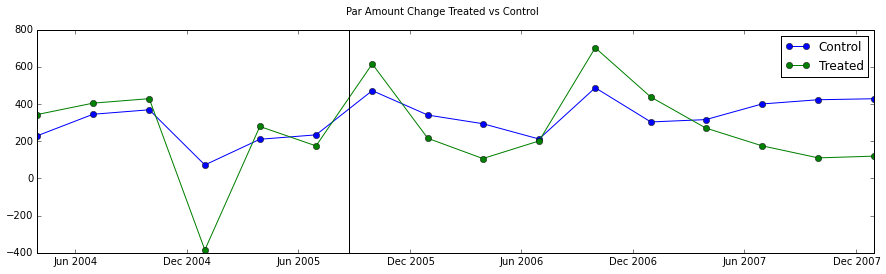

In [26]:
zmr = 300
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    for i in (0,1):
        tmp = tmp_pvt.loc(axis=0)[:,:,[i]]
        ax1.plot(tmp.yq, tmp.par_amount_change, 'go-' if i else 'bo-', label="Treated" if i else "Control")
    #ax1.set_xticklabels([x for x in ax1.get_xticklabels()])
    ax1.axvline(color='black', x=KATRINA_DATE)
    ax1.legend()
    fig.suptitle('Par Amount Change Treated vs Control')

### 5. Link all SA IDs to Holding
**`sq_holding_all_collapsed`** will have cusip6, year, quarter level obervations.
Importantly, columns **`par_amount`** and **`par_amount_treated`** will be the amount of outstanding bonds held by errbudy and affected insurance companies respectively.

In [27]:
sq_holding_all_collapsed = (
  sa.select([sq_holding_all.c.cusip6,
             sq_holding_all.c.year,
             sq_holding_all.c.quarter,
             sa.func.sum(sq_holding_all.c.par_amount).label('par'),
             sa.func.sum(sq_holding_all.c.par_amount_change).label('par_change'),
             sa.func.sum(sq_holding_all.c.par_amount.op("*")(
                         sq_holding_all.c.treated)).label('par_treated'),
             sa.func.sum(sq_holding_all.c.par_amount_change.op("*")(
                         sq_holding_all.c.treated)).label('par_change_treated'),])
    .select_from(sq_holding_all)
    .group_by(sq_holding_all.c.cusip6,
              sq_holding_all.c.year,
              sq_holding_all.c.quarter,)
    .order_by(sq_holding_all.c.year,
              sq_holding_all.c.quarter,
              sq_holding_all.c.cusip6,)
).alias('sq_holding_all_collapsed')

In [28]:
pg_head(sq_holding_all_collapsed)

,cusip6,year,quarter,par,par_change,par_treated,par_change_treated
0,00023*,2004,1,47326,-12259,0,0
1,000336,2004,1,68853,-2870,0,0
2,00036*,2004,1,0,-1961,0,0
3,000361,2004,1,137150,13120,0,0
4,00036A,2004,1,179000,0,0,0


### 6. Link in firm names for matching.

In [57]:
set(df_comp.index).add('poo')

In [29]:
sq_holding_final = (
  sa.select(sq_holding_all_collapsed.c+
            [psql_tables['issuers'].c.name
             ,psql_tables['issuers'].c.ticker
             ,psql_tables['issuers'].c.country])
    .select_from(sa.join(sq_holding_all_collapsed, psql_tables['issuers'],
                         sa.and_(sq_holding_all_collapsed.c.cusip6 == psql_tables['issuers'].c.cusip6,
                                 sq_holding_all_collapsed.c.year == psql_tables['issuers'].c.year,
                                 sq_holding_all_collapsed.c.quarter == psql_tables['issuers'].c.quarter,)))
    .distinct(sq_holding_all_collapsed.c.year,
              sq_holding_all_collapsed.c.quarter,
              sq_holding_all_collapsed.c.cusip6,)
).alias('sq_holding_final')

### 7. Export to csv file

In [30]:
df_emaxx = pg_to_df(sq_holding_final)
for v in [x for x in df_emaxx.columns if x[:3]=='par']:
    df_emaxx[v] = df_emaxx[v].apply(int)

In [31]:
df_emaxx.sort(columns='cusip6,year,quarter'.split(',')
             ).to_csv(os.path.join(ROOTDIR,'all_out.tsv'), index=False)

In [32]:
print("E[\\theta]={:0.4f}\nE[\\theta|treated]={:0.4f}".format(
(df_emaxx[df_emaxx.par > 0].par_treated/(df_emaxx[df_emaxx.par > 0].par)).mean(), \
(df_emaxx[df_emaxx.par_treated > 0].par_treated/(df_emaxx[df_emaxx.par_treated > 0].par)).mean()))

E[\theta]=0.0295
E[\theta|treated]=0.1313


# Sub-account level holding changes

In [33]:
sq_suba_holding = (
  sa.select(sql_sa.c +
            [sa.case([(sql_sa.c.sub_account_id.in_(sq_sa_ids), 1)], else_=0).label('treated'),])
    .where(sa.and_(sql_sa.c.sub_account_class.in_(SA_CLASSES),
                   sql_sa.c.sub_account_id > 0,
                   sql_sa.c.sub_account_country == "USA"))
    .distinct()
).alias('sq_suba_holding')

In [34]:
tmp = pg_to_df(sq_suba_holding)
tmp = add_column(tmp, 'date', lambda x: dt.datetime(x['year'], x['quarter']*3, 30))

In [35]:
tmpp = tmp.pivot_table(index=['date','treated'], aggfunc='sum')
tmpp.head(4).transpose()

date                     2000-03-30             2000-06-30           
treated                           0          1           0          1
managing_firm_id           39632132    1929246    39986859    1923848
quarter                        3078        180        6266        370
sub_account_id             91358426    4800977    92396175    4961872
total_number_bonds_held      641430      62038      659186      63137
total_par_amt_held       1987841861  240100509  2005314639  242306859
year                        6156000     360000     6266000     370000

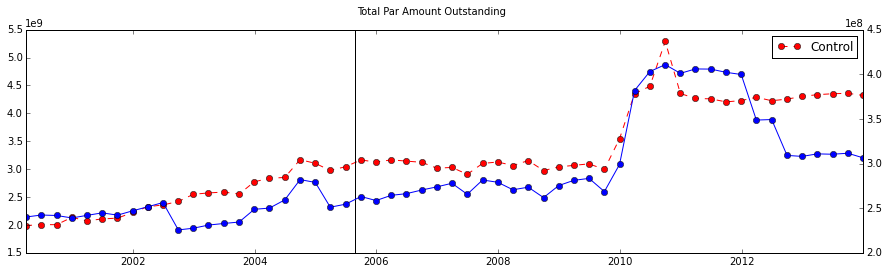

In [36]:
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    for i in (0,1):
        axtmp = ax1.twinx() if i else ax1
        axtmp.plot(tmpp.xs(i, level='treated').index, 
                 tmpp.xs(i, level='treated').total_par_amt_held,
                 'bo-' if i else 'ro--',
                 label="Treated" if i else "Control")
    ax1.axvline(color='black', x=KATRINA_DATE)
    ax1.legend()
    fig.suptitle('Total Par Amount Outstanding')

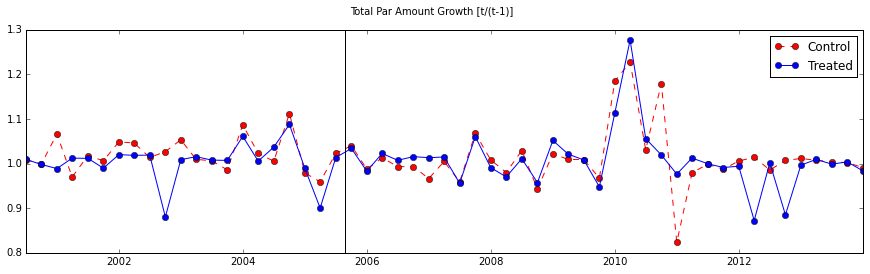

In [37]:
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    for i in (0,1):
        tmpi = tmpp.xs(i, level='treated')
        ax1.plot(tmpi.index,
                 tmpi.total_par_amt_held/tmpi.total_par_amt_held.shift(),
                 'bo-' if i else 'ro--',
                 label="Treated" if i else "Control")
    ax1.axvline(color='black', x=KATRINA_DATE)
    ax1.legend()
    fig.suptitle('Total Par Amount Growth [t/(t-1)]')

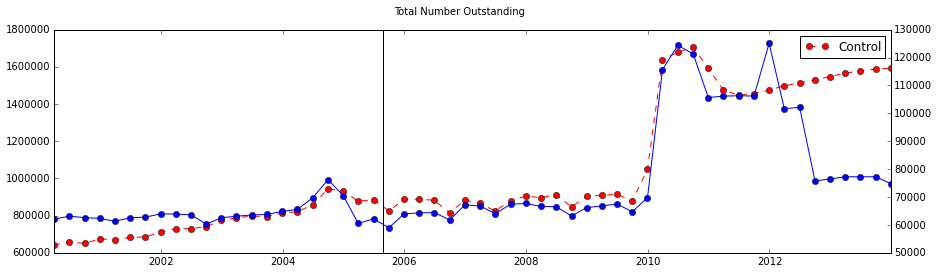

In [38]:
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    for i in (0,1):
        axtmp = ax1.twinx() if i else ax1
        axtmp.plot(tmpp.xs(i, level='treated').index, 
                 tmpp.xs(i, level='treated').total_number_bonds_held,
                 'bo-' if i else 'ro--',
                 label="Treated" if i else "Control")
    ax1.axvline(color='black', x=KATRINA_DATE)
    ax1.legend()
    fig.suptitle('Total Number Outstanding')

In [39]:
tmpp = tmp.pivot_table(index=['date','treated'], aggfunc='mean')

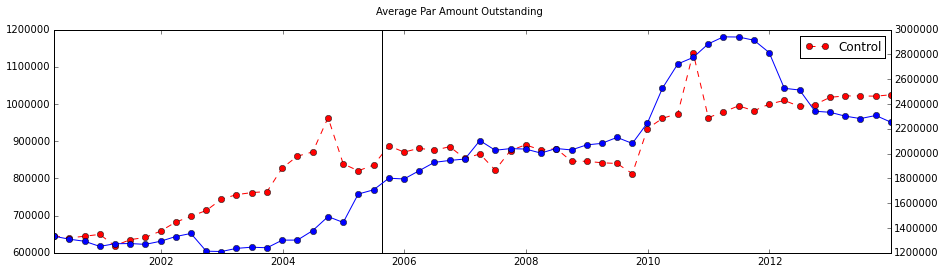

In [40]:
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    for i in (0,1):
        axtmp = ax1.twinx() if i else ax1
        axtmp.plot(tmpp.xs(i, level='treated').index, 
                 tmpp.xs(i, level='treated').total_par_amt_held,
                 'bo-' if i else 'ro--',
                 label="Treated" if i else "Control")
    ax1.axvline(color='black', x=dt.datetime(2005, 8, 17))
    ax1.legend()
    fig.suptitle('Average Par Amount Outstanding')

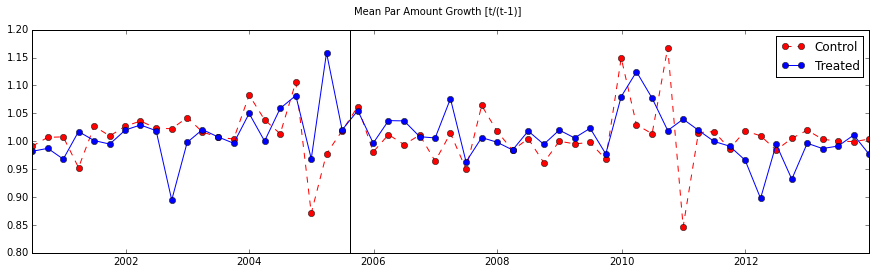

In [41]:
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    for i in (0,1):
        tmpi = tmpp.xs(i, level='treated')
        ax1.plot(tmpi.index,
                 tmpi.total_par_amt_held/tmpi.total_par_amt_held.shift(),
                 'bo-' if i else 'ro--',
                 label="Treated" if i else "Control")
    ax1.axvline(color='black', x=dt.datetime(2005, 8, 17))
    ax1.legend()
    fig.suptitle('Mean Par Amount Growth [t/(t-1)]')

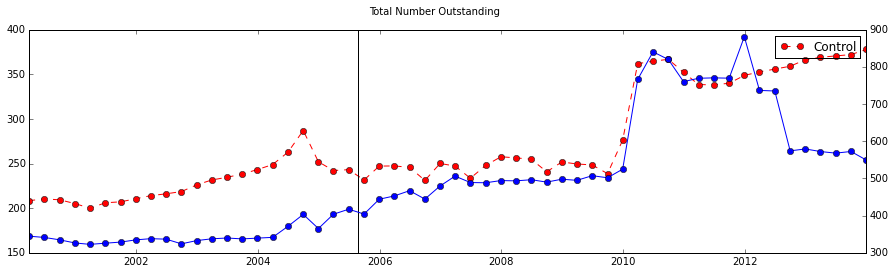

In [42]:
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    for i in (0,1):
        axtmp = ax1.twinx() if i else ax1
        axtmp.plot(tmpp.xs(i, level='treated').index, 
                 tmpp.xs(i, level='treated').total_number_bonds_held,
                 'bo-' if i else 'ro--',
                 label="Treated" if i else "Control")
    ax1.axvline(color='black', x=KATRINA_DATE)
    ax1.legend()
    fig.suptitle('Total Number Outstanding')

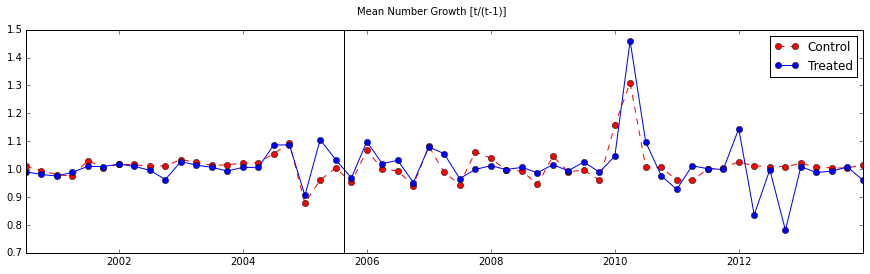

In [43]:
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    for i in (0,1):
        tmpi = tmpp.xs(i, level='treated')
        ax1.plot(tmpi.index,
                 tmpi.total_number_bonds_held/tmpi.total_number_bonds_held.shift(),
                 'bo-' if i else 'ro--',
                 label="Treated" if i else "Control")
    ax1.axvline(color='black', x=dt.datetime(2005, 8, 17))
    ax1.legend()
    fig.suptitle('Mean Number Growth [t/(t-1)]')

# Random descriptives

In [31]:
HTML("<b>EMAXX sample</b>")
df_emaxx.head(2)

EMAXX sample

,cusip6,year,quarter,par,par_change,par_treated,par_change_treated,name,ticker,country
0,00023*,2004,1,47326,-12259,0,0,AAA COOPER TRANSPORTATION,None,USA
1,000336,2004,1,68853,-2870,0,0,AAG HOLDING CO INC (CINCINNATI),None,USA


In [205]:
df_comp = dfs['compcusip'][dfs['compcusip'].year.notnull()]
df_comp.columns = [x.lower() for x in df_comp.columns]
HTML("<b>Compustat sample</b>")
df_comp.head(2)

Compustat sample

,permno,permco,comnam,ticker,cusip,cusip6,date_start,date_end,year,quarter,fic,comp
5649,76868,10817,AAON INC,AAON,00036020,000360,1993-10-18,2004-06-09,2004,1,USA,1
5650,76868,10817,AAON INC,AAON,00036020,000360,1993-10-18,2004-06-09,2004,2,USA,1


In [208]:
df_b = pd.merge(
    df_emaxx[df_emaxx.country == "USA"],
    df_comp[df_comp.fic == "USA"],
    how='outer')
df_b['emaxx'] = df_b.par.notnull() + 0
df_b['comp'] = df_b.permno.notnull() + 0
df_b['both'] = (df_b.emaxx == df_b.comp) + 0

In [200]:
df_b[(df_b.year==2005)&(df_b.quarter==3)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,15270,2005.0000000,0.0000000,2005,2005.00,2005,2005.0,2005
quarter,15270,3.0000000,0.0000000,3,3.00,3,3.0,3
par,9818,181032.6738643,599504.7146774,0,2256.25,17735,119199.0,14122559
par_change,9818,17273.0005093,133746.4068849,-756197,-152.75,0,3650.0,9584267
par_treated,9818,6477.4730088,24574.1098210,0,0.00,0,0.0,509078
par_change_treated,9818,586.7470972,5539.6464080,-59224,0.00,0,0.0,154540
PERMNO,6879,73715.5551679,22626.6220155,10001,75366.00,82816,88448.5,93105
PERMCO,6879,23490.0398314,14048.5545762,5,12342.00,20631,37174.5,51781
comp,15270,0.4504912,0.4975591,0,0.00,0,1.0,1
emaxx,15270,0.6429601,0.4791424,0,0.00,1,1.0,1


In [201]:
df_b[(df_b.year==2005)&(df_b.quarter==3)&(df_b.both==1)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1427,2005.0000000,0.0000000,2005,2005.0,2005,2005.0,2005
quarter,1427,3.0000000,0.0000000,3,3.0,3,3.0,3
par,1427,473488.9376314,1004856.0730091,0,26303.0,129095,420962.5,10999153
par_change,1427,44430.4533987,144740.4037594,-756197,-378.5,3405,32135.5,1733574
par_treated,1427,17542.1983181,43446.5208715,0,0.0,415,14000.0,509078
par_change_treated,1427,1942.0791871,10185.2295148,-47497,0.0,0,103.5,106750
PERMNO,1427,64018.1793973,25543.7106955,10025,45611.5,76638,84541.0,92663
PERMCO,1427,19057.5963560,11867.4445574,25,10404.0,20283,23768.0,47008
comp,1427,1.0000000,0.0000000,1,1.0,1,1.0,1
emaxx,1427,1.0000000,0.0000000,1,1.0,1,1.0,1


### Previous run results

In [160]:
df_b[(df_b.year==2005)&(df_b.quarter==3)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,16744,2005.0000000,0.0000000,2005,2005.00,2005.0,2005.00,2005
quarter,16744,3.0000000,0.0000000,3,3.00,3.0,3.00,3
par,9790,179930.7165475,597396.0210719,0,2250.75,17620.5,118434.50,14122559
par_change,9790,17075.6979571,133480.6876211,-756197,-151.75,0.0,3618.25,9584267
par_treated,9790,6449.7221655,24539.6263506,0,0.00,0.0,0.00,509078
par_change_treated,9790,584.6133810,5542.6801817,-59224,0.00,0.0,0.00,154540
gvkey,8372,72610.9930721,63731.5266292,1004,14449.00,61539.0,139388.00,277918
cik,8040,856896.1871891,392978.3027562,20,773080.00,922041.0,1099574.25,1635235
emaxx,16744,0.5846871,0.4927906,0,0.00,1.0,1.00,1
comp,16744,0.5000000,0.5000149,0,0.00,0.5,1.00,1


In [161]:
df_b[(df_b.year==2005)&(df_b.quarter==3)&(df_b.both==1)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1418,2005.0000000,0.0000000,2005,2005.00,2005.0,2005.00,2005
quarter,1418,3.0000000,0.0000000,3,3.00,3.0,3.00,3
par,1418,465493.0712271,994080.0916055,0,30605.00,129448.5,444818.25,10999153
par_change,1418,43014.8737659,143781.4553471,-756197,-265.75,3937.0,31097.75,1733574
par_treated,1418,18276.0056417,45009.2755502,0,0.00,605.0,15000.00,509078
par_change_treated,1418,1733.1248237,9845.2775206,-47497,0.00,0.0,0.00,106750
gvkey,1418,41438.6488011,51018.4342378,1004,7366.50,14415.0,63182.25,264397
cik,1410,629675.9631206,446835.0927728,1750,85964.25,814502.0,1016059.00,1617667
emaxx,1418,1.0000000,0.0000000,1,1.00,1.0,1.00,1
comp,1418,1.0000000,0.0000000,1,1.00,1.0,1.00,1


In [126]:
df_emaxx.dtypes

cusip6                object
year                   int64
quarter                int64
par                    int64
par_change             int64
par_treated            int64
par_change_treated     int64
name                  object
ticker                object
country               object
dtype: object

In [216]:
comp_names = sorted(df_comp.comnam.unique())
emaxx_names = sorted(df_emaxx[df_emaxx.par > 10000].name.unique())
len(comp_names), len(emaxx_names)

(8986, 13731)

In [218]:
[x for x in comp_names if re.search('fitness', x, re.IGNORECASE)]

['BALLY TOTAL FITNESS HOLDING CORP',
 'HEALTH FITNESS CORP',
 'LIFE TIME FITNESS INC']

In [224]:
def getbest(searchfor, searchin):
    x = extractOne(searchfor, searchin)
    if x[1] > 95:
        return searchfor, x[0]
    return None

for name in emaxx_names:
    res = getbest(name, comp_names)
    if res:
        print(name)
        print("\t{}".format(res))
        break

21ST CENTURY INSURANCE GROUP
	('21ST CENTURY INSURANCE GROUP', '21ST CENTURY INSURANCE GROUP')


In [232]:
from IPython.parallel import Client
IP_client = Client()
IP_view = IP_client.load_balanced_view()

In [233]:
pickle.dump(comp_names, open('/tmp/comp_names.pkl', 'wb'))

In [258]:
%%px --local

import pickle
from functools import partial
from fuzzywuzzy.process import extractOne

comp_names_parallel = pickle.load(open('/tmp/comp_names.pkl', 'rb'))

def getbest(searchfor, searchin=None):
    x = extractOne(searchfor, searchin)
    if x[1] > 80:
        return {'emaxx':searchfor, 'comp':x[0]}
    return None

search_in = partial(getbest, searchin=comp_names_parallel)

In [259]:
print(search_in(emaxx_names[13]))

{'comp': '21ST CENTURY INSURANCE GROUP', 'emaxx': '21ST CENTURY INSURANCE GROUP'}


In [309]:
tmp_res = IP_view.map(search_in, emaxx_names)

In [308]:
from time import sleep

In [310]:
tmp_res.progress

311

while tmp_res.progress <= len(emaxx_names)-10:
    print(tmp_res.progress)
    with open("/home/gaulinmp/Desktop/current.txt", 'w') as fh:
        fh.write(str(tmp_res.progress))
    sleep(30)
pickle.dump([x for x in tmp_res.result if x], 
            open("/home/gaulinmp/Desktop/results_{:%Y%m%d}.pkl".format(dt.date.today()), 'wb'))

In [4]:
loaded_res = pickle.load(open("/home/gaulinmp/Desktop/results.pkl", 'rb'))

In [314]:
len([x for x in tmp_res.result if x])

1433

In [119]:
tmp2 = tmp.copy()

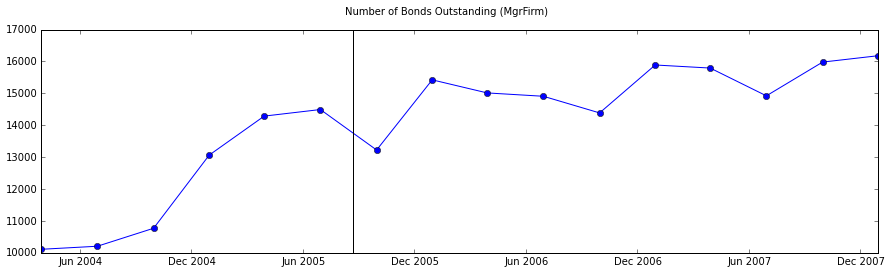

In [241]:
query = (sa.select(columns=[sql_holding.c.year, 
                            sql_holding.c.quarter, 
                            sa.func.count().label('num')]
                   , limit=None)
           .where(sa.and_(sql_holding.c.managing_firm_id.in_(mids),
                          sql_holding.c.year.in_([2004,2005,2006,2007])))
           .group_by(sql_holding.c.year, sql_holding.c.quarter)
           .order_by(sql_holding.c.year, sql_holding.c.quarter)
        )
tmp = pg_to_df(query)
tmp = add_column(tmp, 'date', lambda x: dt.datetime(x['year'], x['quarter']*3, 30))
zmr = 300
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax1.plot(tmp.date, tmp.num, 'bo-')
    ax1.axvline(color='black', x=KATRINA_DATE)
    fig.suptitle('Number of Bonds Outstanding (MgrFirm)')

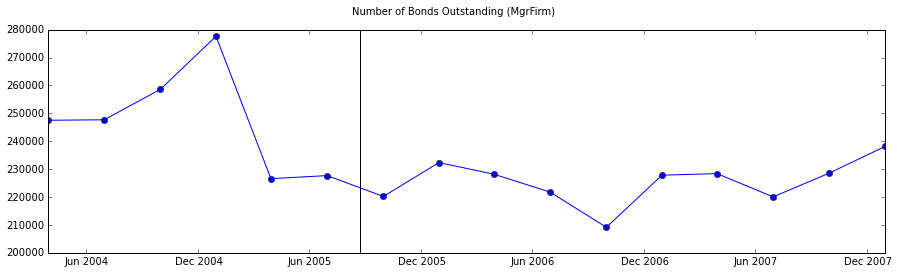

In [242]:
# List of firms with type found in searched firms
sq_firm_types = (
      sa.select([sql_mf.c.managing_firm_type])
        .where(sql_mf.c.managing_firm_id.in_(mids))
        .distinct()
    ).alias('sq_firm_types')

# List of all firms, control and treated of right type
sq_sample_firms = (
      sa.select([sql_mf.c.managing_firm_id], distinct=True)
        .where(sa.and_(
            sql_mf.c.managing_firm_type.in_(sq_firm_types)
            ,sql_mf.c.managing_firm_id.notin_(mids)
        ))
    ).alias('sq_sample_firms')

# Count holdings for sample firms.
query = (sa.select([sql_holding.c.year, 
                    sql_holding.c.quarter, 
                    sa.func.count().label('num')], limit=500)
           .distinct()
           .where(sa.and_(sql_holding.c.managing_firm_id.in_(sq_sample_firms),
                          sql_holding.c.year.in_([2004,2005,2006,2007])))
           .group_by(sql_holding.c.year, sql_holding.c.quarter)
           .order_by(sql_holding.c.year, sql_holding.c.quarter)
        )

tmp = pg_to_df(query)
tmp = add_column(tmp, 'date', lambda x: dt.datetime(x['year'], x['quarter']*3, 30))
zmr = 300
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax1.plot(tmp.date, tmp.num, 'bo-')
    ax1.axvline(color='black', x=KATRINA_DATE)
    fig.suptitle('Number of Bonds Outstanding (MgrFirm)')

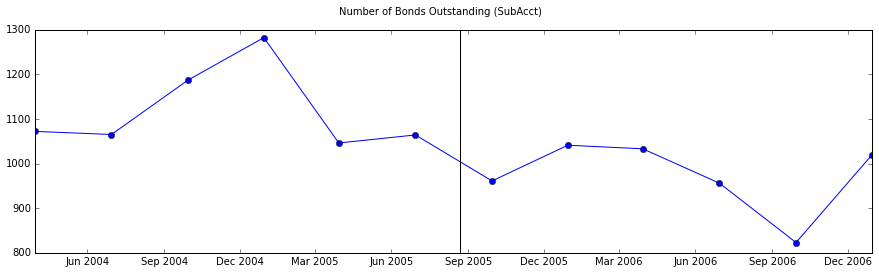

In [243]:
query = (sa.select(columns=[sql_holding.c.year, 
                            sql_holding.c.quarter, 
                            sa.func.count().label('num')]
                   , limit=None)
           .where(sa.and_(sql_holding.c.sub_account_id.in_(saids),
                          sql_holding.c.year.in_([2004,2005,2006])))
           .group_by(sql_holding.c.year, sql_holding.c.quarter)
           .order_by(sql_holding.c.year, sql_holding.c.quarter)
        )
tmp = pg_to_df(query)
tmp = add_column(tmp, 'date', lambda x: dt.datetime(x['year'], x['quarter']*3, 30))
zmr = 300
if plots:
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax1.plot(tmp.date, tmp.num, 'bo-')
    ax1.axvline(color='black', x=KATRINA_DATE)
    fig.suptitle('Number of Bonds Outstanding (SubAcct)')

In [57]:
stmnt = (sa.select(columns=sql_holding.c, limit=None)
           .where(sql_holding.c.managing_firm_id.in_(mids)) 
        ).alias('stmnt')
query = (sa.select(columns=[stmnt.c.year,
                            stmnt.c.quarter,
                            sa.func.sum(stmnt.c.par_amount_change).label('ave_par_amount_change')]
                   , limit=None)
            .group_by(stmnt.c.year, stmnt.c.quarter)
            .order_by(stmnt.c.year, stmnt.c.quarter)
        )
dataframe = pg_to_df(query)
dataframe.head()

,year,quarter,ave_par_amount_change
0,2000,1,1411115
1,2000,2,1917656
2,2000,3,938732
3,2000,4,1368692
4,2001,1,2624507


In [60]:
stmnt = (sa.select(columns=sql_holding.c, limit=None)
           .where(sql_holding.c.managing_firm_id.notin_(mids)) 
        ).alias('stmnt')
query = (sa.select(columns=[stmnt.c.year,
                            stmnt.c.quarter,
                            sa.func.sum(stmnt.c.par_amount_change).label('ave_par_amount_change')]
                   , limit=None)
            .group_by(stmnt.c.year, stmnt.c.quarter)
            .order_by(stmnt.c.year, stmnt.c.quarter)
        )
with engine.connect() as connection:
    results = (connection
               .execution_options(stream_results=True)
               .execute(query))
    dataframe2 = pd.DataFrame(iter(results))
    dataframe2.columns = results.keys()
    dataframe2.sort(columns=['year','quarter'])
dataframe2.head()

,year,quarter,ave_par_amount_change
0,2000,1,81406175
1,2000,2,36124386
2,2000,3,46028654
3,2000,4,149838520
4,2001,1,64616486


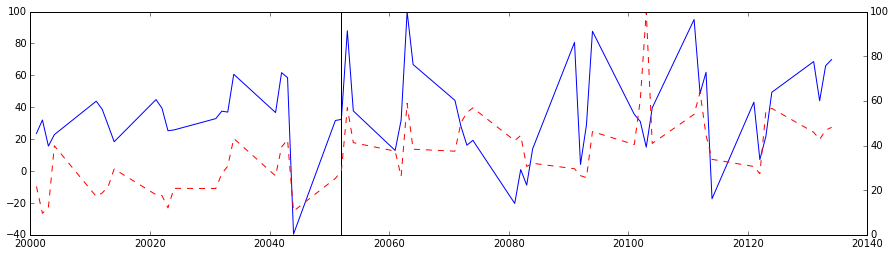

In [64]:
lookup = 'forecasts'
zmr = 300
tmp = [a*10 + b for a,b in dataframe['year,quarter'.split(',')].values]
if True:
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax2 = ax1.twinx()
    ax1.plot(tmp, dataframe.ave_par_amount_change/dataframe.ave_par_amount_change.max()*100, )
    ax2.plot(tmp, dataframe2.ave_par_amount_change/dataframe2.ave_par_amount_change.max()*100, 'r--')
    ax1.axvline(color='black', x=20052)

In [56]:
query = (sa.select(columns=[sa.func.sum(sql_holding.c.par_amount_change)]
                   , limit=None)
#        .where(sql_holding.c.cusip6=='001957')
#        .where(sql_holding.c.cusip78=='AV')
        .where(sql_holding.c.managing_firm_id.in_(mids))
        .group_by(sql_holding.c.year, sql_holding.c.quarter)
        )
with engine.connect() as connection:
    results = (connection
               .execution_options(stream_results=True)
               .execute(query))
    tmpdf = pd.DataFrame(iter(results))
    tmpdf.columns = results.keys()
print(len(tmpdf.index))
tmpdf.head()

56


,sum_1
0,5271737
1,2319102
2,2958539
3,2129283
4,2358359


In [104]:
tmpdf['year,quarter,sub_account_id,par_amount,report_date,par_amount_change,acquisition_book_value'.\
      split(',')].sort('sub_account_id').dtypes

year                      object
quarter                   object
sub_account_id            object
par_amount                object
report_date               object
par_amount_change         object
acquisition_book_value    object
dtype: object

In [47]:
kill_pg_connection()

Didn't close query.


# Compustat Data

In [44]:
df_comp = pd.read_csv('../../comp_data.tab', sep='\t', parse_dates=['date_start', 'date_end', 'date'])
df_comp.columns = [x.lower() for x in df_comp.columns]
df_comp = pd.merge(df_comp, 
                   ((df_comp[['gvkey','par_treated']].groupby('gvkey').min()>0)+0).reset_index(), 
                   on='gvkey', suffixes=('', '_bool'))
#print(df_comp.head(1).dtypes)

In [45]:
deets = \
df_comp[['date', 'atq', 'ltq', 'niq', 'req',
         'par', 'par_change', 'par_treated', 'par_change_treated',
         'how_treated', 'treated_rank', 'katrina_rank']
       ].groupby(['date', 'treated_rank']).describe()

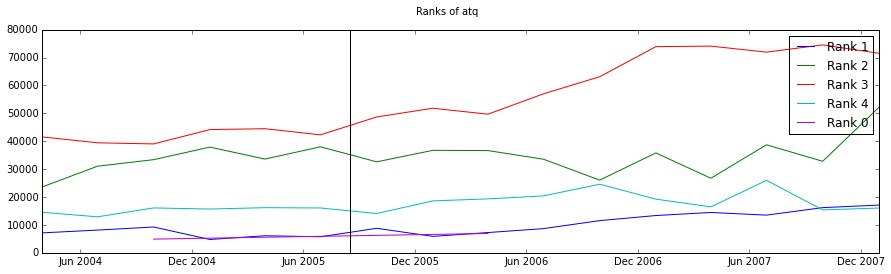

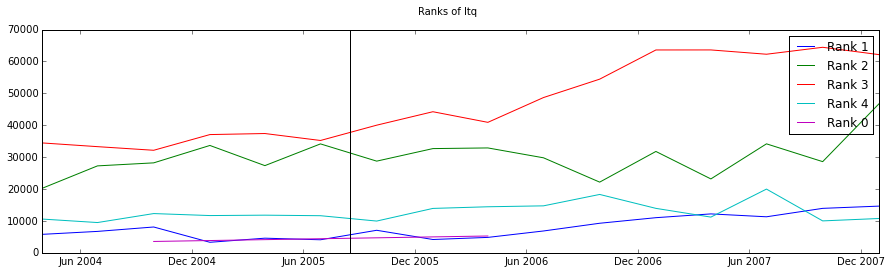

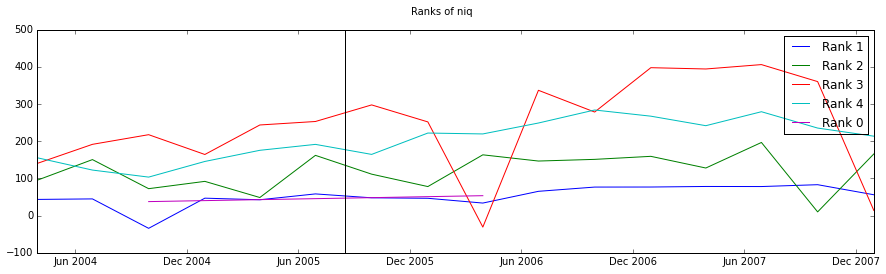

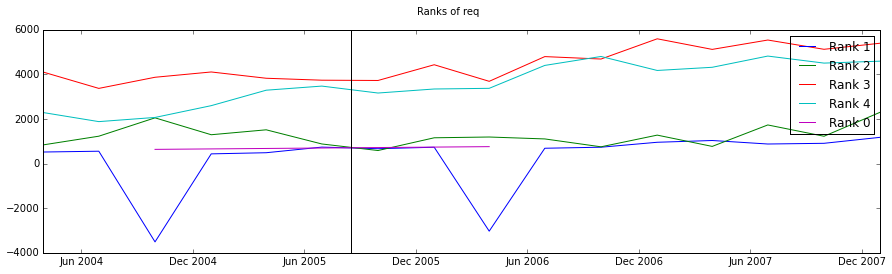

In [46]:
if plots:
    for var_to_plot in ['atq', 'ltq', 'niq', 'req']:
        fig, ax1 = plt.subplots(figsize=(15,4))
        summ_stat =  'mean'
        for i in deets.index.get_level_values(1).unique():
            tmpi = deets.xs(i, level='treated_rank').xs(summ_stat, level=1)
            ax1.plot(tmpi.index,
                     tmpi[var_to_plot],
                     label="Rank {}".format(i))
        ax1.axvline(color='black', x=dt.datetime(2005, 8, 17))
        ax1.legend()
        fig.suptitle('Ranks of {}'.format(var_to_plot))

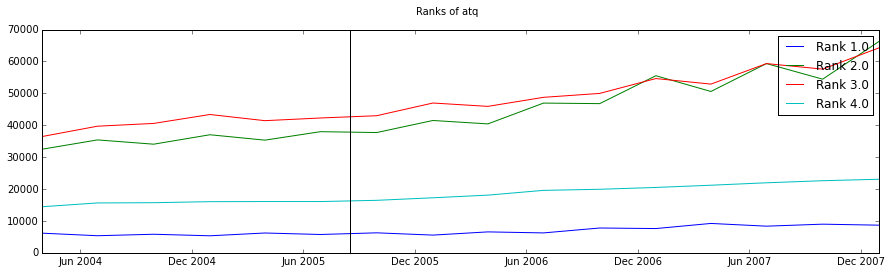

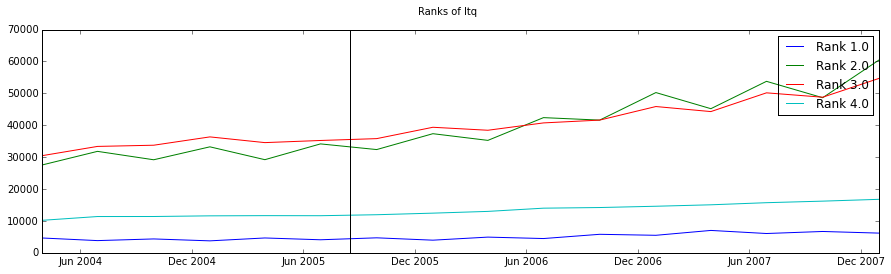

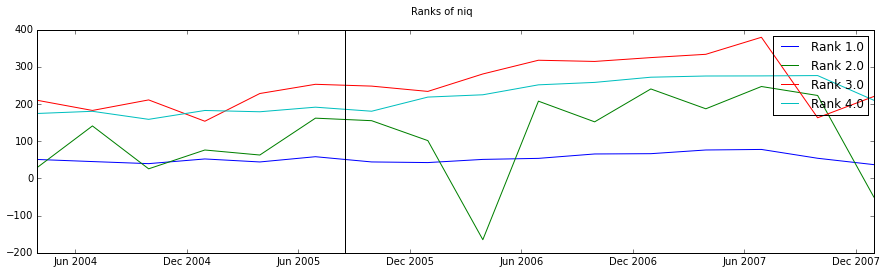

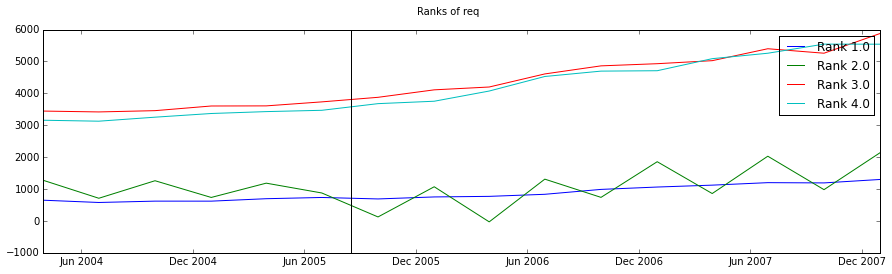

In [47]:
deets = df_comp[
    ['date', 'atq', 'ltq', 'niq', 'req',
     'par', 'par_change', 'par_treated', 'par_change_treated',
     'how_treated', 'treated_rank', 'katrina_rank']
    ].groupby(['date', 'katrina_rank']).describe()
if plots:
    for var_to_plot in ['atq', 'ltq', 'niq', 'req']:
        fig, ax1 = plt.subplots(figsize=(15,4))
        summ_stat =  'mean'
        for i in deets.index.get_level_values(1).unique():
            tmpi = deets.xs(i, level='katrina_rank').xs(summ_stat, level=1)
            ax1.plot(tmpi.index,
                     tmpi[var_to_plot],
                     label="Rank {}".format(i))
        ax1.axvline(color='black', x=dt.datetime(2005, 8, 17))
        ax1.legend()
        fig.suptitle('Ranks of {}'.format(var_to_plot))

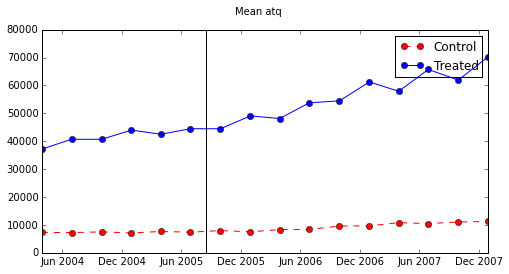

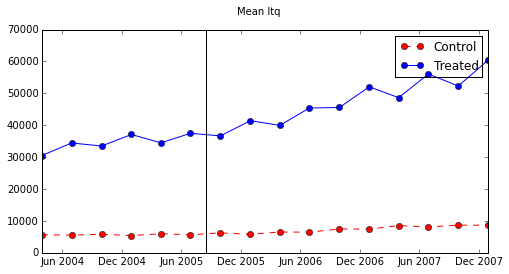

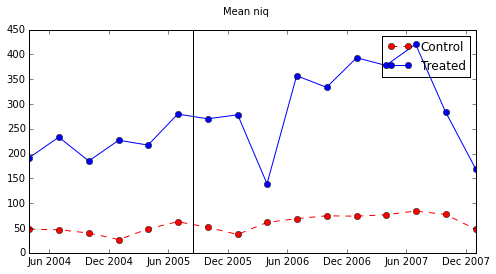

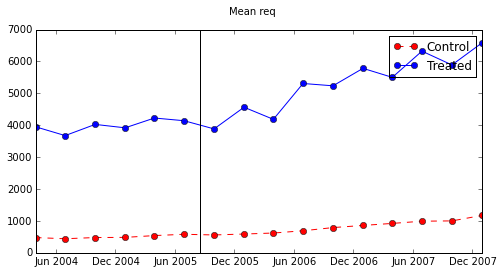

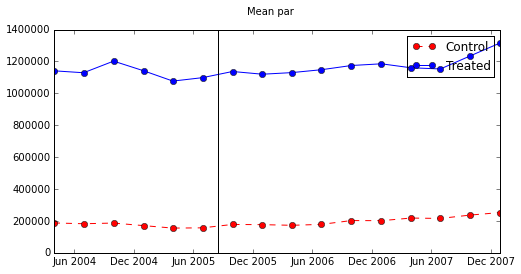

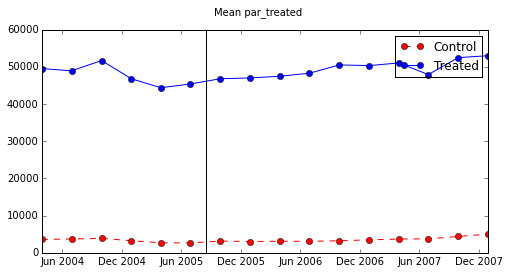

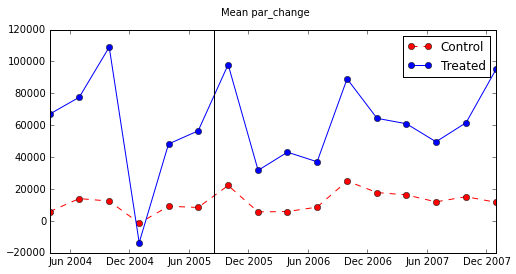

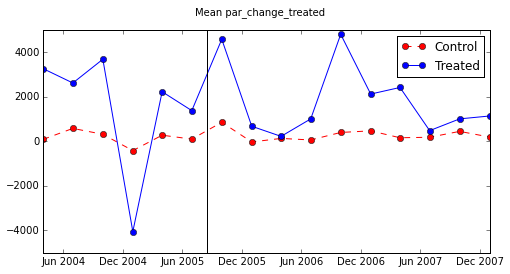

In [48]:
deets = df_comp[df_comp.katrina_rank.notnull()][
    ['date', 'atq', 'ltq', 'niq', 'req', 'par_treated_bool',
     'par', 'par_change', 'par_treated', 'par_change_treated',
     'how_treated', 'treated_rank', 'katrina_rank']
    ].groupby(['date', 'par_treated_bool']).describe()
if plots:
    for var_to_plot in ['atq', 'ltq', 'niq', 'req', 'par', 'par_treated',
                        'par_change', 'par_change_treated']:
        fig, ax1 = plt.subplots(figsize=(8,4))
        summ_stat =  'mean'
        for i in deets.index.get_level_values(1).unique():
            tmpi = deets.xs(i, level='par_treated_bool').xs(summ_stat, level=1)
            ax1.plot(tmpi.index,
                     tmpi[var_to_plot],
                     'bo-' if i else 'ro--',
                     label="Treated" if i else "Control")
        ax1.axvline(color='black', x=dt.datetime(2005, 8, 17))
        ax1.legend()
        fig.suptitle('Mean {}'.format(var_to_plot))

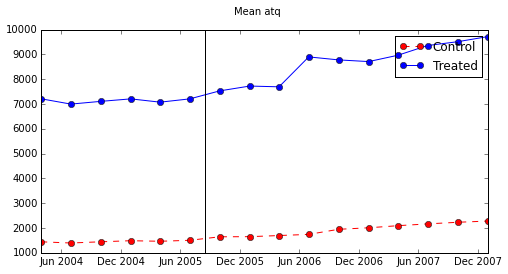

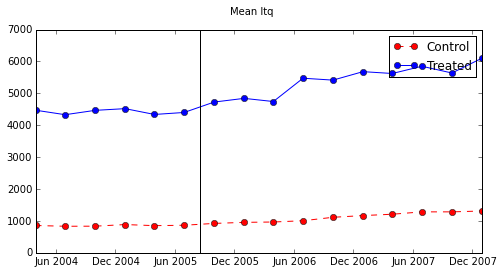

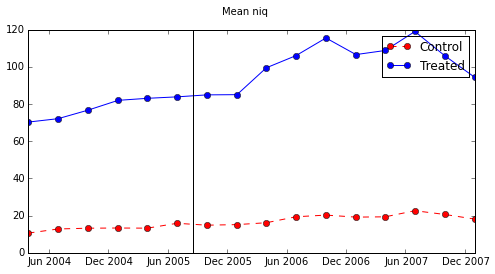

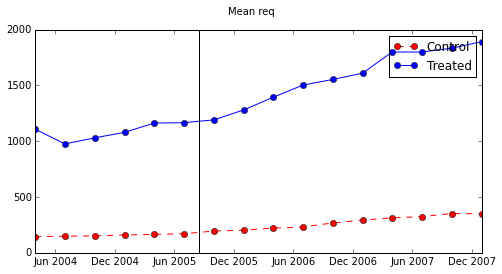

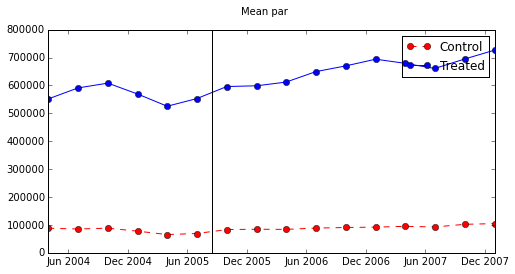

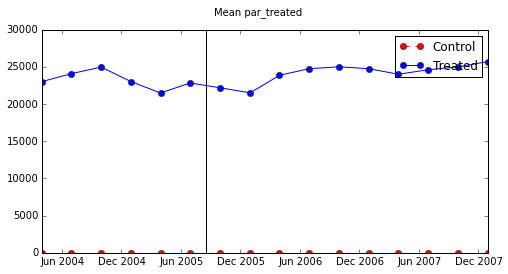

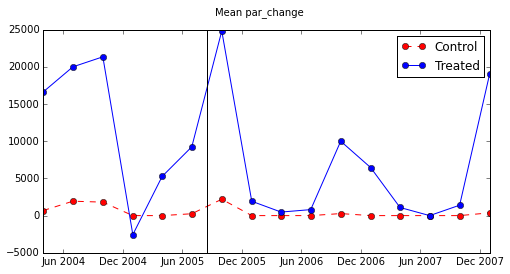

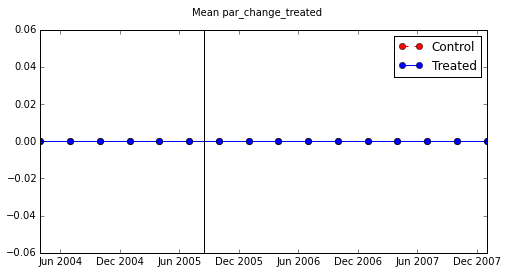

In [49]:
deets = df_comp[df_comp.katrina_rank.notnull()][
    ['date', 'atq', 'ltq', 'niq', 'req', 'par_treated_bool',
     'par', 'par_change', 'par_treated', 'par_change_treated',
     'how_treated', 'treated_rank', 'katrina_rank']
    ].groupby(['date', 'par_treated_bool']).describe()
if plots:
    for var_to_plot in ['atq', 'ltq', 'niq', 'req', 'par', 'par_treated',
                        'par_change', 'par_change_treated']:
        fig, ax1 = plt.subplots(figsize=(8,4))
        summ_stat =  '50%'
        for i in deets.index.get_level_values(1).unique():
            tmpi = deets.xs(i, level='par_treated_bool').xs(summ_stat, level=1)
            ax1.plot(tmpi.index,
                     tmpi[var_to_plot],
                     'bo-' if i else 'ro--',
                     label="Treated" if i else "Control")
        ax1.axvline(color='black', x=dt.datetime(2005, 8, 17))
        ax1.legend()
        fig.suptitle('Mean {}'.format(var_to_plot))